## import

In [1]:
import csv
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import pyreadr
import matplotlib
from tqdm import tqdm
from scipy import stats

## setup params

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 16

In [3]:
notvalid = [x for x in range(34,41)]
notvalid.extend([9,11,20,25,42])
valid_patients_pupil = [ele for ele in range(1,56) if ele not in notvalid]

notvalid = [x for x in range(34,41)]
notvalid.append(9)
valid_patients_eda = [ele for ele in range(1,56) if ele not in notvalid]

valid_pupil_eda = list(set(valid_patients_eda).intersection(set(valid_patients_pupil)))

notvalid = [x for x in range(34, 41)]
notvalid= notvalid + [9,11,12,20]
valid_patients_hr = [ele for ele in range(1, 56) if ele not in notvalid]

## global var

In [4]:
NUM_TRIALS = 160
LATENCY_HR = 250
LATENCY_EDA = 5000
LATENCY_PUPIL = 1000
SAMPLING_RATE_HR = 500
SAMPLING_RATE_EDA = 500
SAMPLING_RATE_PUPIL = 100

## heart rate functions

In [5]:
def extract_hr_by_subject(subject_number: int) -> pd.DataFrame:
    """
    Extract heart data of the subject (reading tmp_hr csv files in tmp_hr folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_hr:
        print('subject number not valid, probably this patient has not valid hr signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_ = pd.read_csv(path_csv)
    df = {'subject': subject_number, 'hr': pat_['CH2'], 'trigger': pat_['CH28']}
    return pd.DataFrame(df)


def all_subject_hr() -> pd.DataFrame:
    """
    Create a single dataframe containing all the hr values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'hr', 'trigger'])
    for i in tqdm(valid_patients_hr):
        df_ = modified_hr_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df

'''
def modified_hr_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the hr from the given subjects and applies some changes: NO ACTION now
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    df = extract_hr_by_subject(subject)
    return df
'''

def modified_hr_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the hr from the given subjects and applies NOTHING
    :param subject:
    :return: new Dataframe with the corrected hr values
    """
    df_ = extract_hr_by_subject(subject)
    df_ = add_latency(df_, -250,500) #TODO INSERT CORRECT VALUE OF LATENCY
    return df_


## pupil functions

In [6]:
def read_csv_pupil_raw(subject_number:int) -> pd.DataFrame:
    """
    Read pupil csv files
    :param subject_number:
    :return: A dataframe with pupil data of the subject subject_number
    """
    if subject_number not in valid_patients_pupil:
        print('subject number not valid, probably this patient has not valid pupil signals')
        return pd.DataFrame()
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    pupil1 = pd.read_csv('../osfstorage-archive/eye/pupil/Look0' + str(subject_number) + '_pupil.csv', sep=';')
    for i in pupil1.columns:
        if i != 'trial':
            for j in pupil1.index:
                pupil1.loc[j, i] = pupil1.loc[j, i].replace(',', '.')
    cols = pupil1.columns.drop('trial')

    pupil1[cols] = pupil1[cols].apply(pd.to_numeric, errors='coerce')
    return pupil1

def create_csv_pupil():
    """
    Create in current folder one tmp csv well formatted with pupil data for each subject
    :return: nothing
    """
    for subject in valid_patients_pupil:
        pupil_i = read_csv_pupil_raw(subject)
        name = 'tmp_pupil/tmp_pupil' + str(subject) + '.csv'
        pupil_i.to_csv(name, index=False)

def read_csv_pupil(subject:int) -> pd.DataFrame:
    """
    Read in current folder one tmp csv well formatted with pupil data
    :param subject:
    :return: Dataframe with pupil data of the subject
    """
    name = 'tmp_pupil/tmp_pupil'+str(subject)+'.csv'
    return pd.read_csv(name, sep=',')

def extract_pupil_by_subject(subject_number:int) -> list:
    """
    Extract pupil data of the subject and return same data in one list adding NaN values to reach same trial length of eda data
    :param subject_number:
    :return:
    """
    pupil = read_csv_pupil(subject_number)
    pupil_ = pupil.copy().drop(['trial'], axis=1)
    # convert all datas into one list
    pat1_pupil = []
    len_eda = int(len_trial_eda(subject_number))
    for i in range(160):
        raw_list = pupil_.loc[i, :].values.flatten().tolist()
        pat1_pupil = pat1_pupil + raw_list
    # pat1_pupil

    return pat1_pupil

def correct_pupil_diam(l:list)->list:
    """
    Shift the pupil diameter values
    :param l: pupil diameter list
    :return: A list containing new pupil shifted
    """
    ADD_SHIFT = -2
    MULT_SHIFT = 4
    return [(x+ADD_SHIFT)*MULT_SHIFT if x != 'NaN' else float('NaN') for x in l]

def extract_maxpupil_trial(subject: int) -> list:
    """
    Calculate the max value of pupil signal in each trial.
    :param subject:
    :return: a list with same length of the pupil signal filled with 0 or 1. 1 if the equivalent value is a max, 0 otherwise
    """
    pupil_csv = read_csv_pupil(subject)
    max_list = []
    max_length = max(700, int(len_trial_eda(subject)))
    for i in range(160):
        max_trial_list = list(pupil_csv.loc[i])[1:]
        max_ = max(max_trial_list)
        max_index = max_trial_list.index(max_)
        for j in range(max_length):
            if j == max_index:
                max_list.append(1)
            else:
                max_list.append(0)
    return max_list

def all_subject_pupil() -> pd.DataFrame:
    """
    Create a dataframe with all pupil data of all subject after adding latency
    :return: a dataframe with all pupil data of all subject with columns ['pupil_diameter', 'pupil_peak', 'subject']
    """
    generic_df = pd.DataFrame(columns=['pupil_diameter', 'subject'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_pupil_subject(i)
        generic_df = pd.concat([generic_df, df_], axis=0)

    return generic_df

def modified_pupil_subject(subject):
    # print(f'pupil: {subject}')
    person_i_all_pupil = extract_pupil_by_subject(subject)
    max_list_i = extract_maxpupil_trial(subject)
    # print(f'person: {len(person_i_all_pupil)}, max: {len(max_list_i)}')
    dict_ = {'pupil_diameter': person_i_all_pupil,
             'subject': subject}
    df_ = pd.DataFrame(dict_)
    df_ = add_latency(df_, -1000,100)
    # df_['time'] = np.arange(0, len(df_) / 100, 0.01)
    return df_


## Eda functions

In [7]:
def len_trial_eda(subject:int) -> int:
    """
    Calculate the length of the trial of the eda signal given subject number
    :param subject:
    :return: int that indicates the length
    """
    df_subject = modified_eda_by_subject(subject)
    return len(df_subject)/NUM_TRIALS

def extract_eda_by_subject(subject_number: int) -> list:
    """
    Extract eda data of the subject (reading tmp_eda csv files in current folder) and return same data in one list
    :param subject_number:
    :return:
    """
    if subject_number not in valid_patients_eda:
        print('subject number not valid, probably this patient has not valid eda signals')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str("tmp_eda/tmp_eda" + str(subject_number) + ".csv")
    pat_eda = pd.read_csv(path_csv)['CH1']
    return pat_eda.to_numpy()

def all_subject_eda() -> pd.DataFrame:
    """
    Create a single dataframe containing all the EDA values of all subjects
    :return:
    """
    generic_df = pd.DataFrame(columns=['subject', 'phasic', 'phasic_peak'])
    for i in tqdm(valid_pupil_eda):
        df_ = modified_eda_by_subject(i)
        #df_['time'] = np.arange(0, len(signals) / 100, 0.01)[:len(df_)] #no sense sta cosa ma senza non va
        generic_df = pd.concat([generic_df, df_], axis=0)
    return generic_df

def modified_eda_by_subject(subject: int) -> pd.DataFrame:
    """
    Read the EDA from the given subjects and applies all the changes: removing last zeros from the list and the outliers at the end
    :param subject:
    :return: new Dataframe with the corrected EDA values
    """
    eda = extract_eda_by_subject(subject)
    # print(f'eda: {i}')
    #eda = resample_eda(eda)
    signals, info = nk.eda_process(eda, sampling_rate=500, method="neurokit")
    eda_phasic = signals['EDA_Phasic']
    #eda_phasic = remove_last_zeros(eda_phasic)
    #eda_phasic = remove_outliers(eda_phasic)
    df = {'subject': subject, 'phasic': eda_phasic, 'phasic_peak': signals['SCR_Peaks'][:len(eda_phasic)]}
    df_ = pd.DataFrame(df)
    df_ = add_latency(df_, -5000, 500)
    return df_


## general functions

In [8]:
def start_trial_time(df:pd.DataFrame)-> list:
    """

    :param df: a dataframe with index in position 0, colum time in position 3 and trigger in position 2
    :return: a list of time where starts trial using trigger as a rectangular activation function
    """
    start_trials = [] #TODO optimize this function.too much time
    prec = -1
    for i in tqdm(df.iterrows()):
        actual = i[1][2]
        if actual == 5 and prec == 0:
            start_trials.extend([i[1][3]])
        prec = actual
    return start_trials

def resample(eda_signal:list,freq_init:int,freq_fin:int) -> list:
    """
    Change sampling rate of the eda signal from initial freq to final freq
    :param eda_signal: list of eda_signal
    :param freq_init: initial sampling rate in hz
    :param freq_fin: final sampling rate in hz
    :return: list of eda_signal with sampling rate of 100hz
    """
    if freq_fin>freq_init:
        print("error only downsample")
        return []
    factor = int(freq_fin/freq_init)
    eda_new = []
    for x in range(len(eda_signal)):
        if x % factor == 0:
            eda_new.append(eda_signal[x])
    return eda_new

def add_latency(dataframe:pd.DataFrame, msecs:int, freq:int)->pd.DataFrame:
    """
    It creates the correct 'time' column of the given dataframe.
    :param dataframe:
    :param secs:
    :param freq: sampling of the signal in Hz
    """
    freq_sec = float(1/freq)
    new_df = dataframe
    time_ = []
    first_value = msecs/1000
    for i in range(len(dataframe)):
        time_.append(first_value)
        first_value += freq_sec
    #print(len(time_))
    new_df['time'] = time_
    return new_df

def remove_outliers(l:list) -> list:
    """
    Remove outliers from a given list. An outlier is detected if its zscore exceeds a certain threshold.
    :param l: list
    :return: same list without outliers
    """
    z = np.abs(stats.zscore(l))
    THRESHOLD = 4
    PERC_LEN = 0.80
    # Position of the first outlier
    outliers = np.where(z>THRESHOLD)[0]
    for x in outliers:
        if x > PERC_LEN*len(l):
            l = l[:x]
            break
    '''
    for x in outliers:
        if x < (1-PERC_LEN)*len(l):
            l = l[x:]
            break
    '''
    return l

def remove_last_zeros(l:list)->list:
    """
    Remove last zeros from the list l, in our case the EDA file
    :param l: list
    :return: same list as l without trailing zeros
    """
    l=list(l)
    if len(l)>0:
        while abs(l[-1]) < 0.01:
            l.pop()
    return l

# test with subject 2

In [9]:
subject_number=2

## extract pupil, eda and hr data of the subject

In [10]:
pupil_one_subj = modified_pupil_subject(subject_number)
pupil_one_subj

,pupil_diameter,subject,time
0,2.215724,2,-1.00
1,2.216014,2,-0.99
2,2.216301,2,-0.98
3,2.216579,2,-0.97
4,2.216844,2,-0.96
...,...,...,...
111995,2.245602,2,1118.95
111996,2.239799,2,1118.96
111997,2.233693,2,1118.97
111998,2.227378,2,1118.98


In [11]:
eda_one_subj = modified_eda_by_subject(subject_number)
eda_one_subj

,subject,phasic,phasic_peak,time
0,2,0.000386,0,-5.000
1,2,0.000044,0,-4.998
2,2,-0.000300,0,-4.996
3,2,-0.000646,0,-4.994
4,2,-0.000995,0,-4.992
...,...,...,...,...
960426,2,-0.002957,0,1915.852
960427,2,-0.002729,0,1915.854
960428,2,-0.002501,0,1915.856
960429,2,-0.002274,0,1915.858


In [12]:
hr_one_subj = modified_hr_by_subject(subject_number)
hr_one_subj

,subject,hr,trigger,time
0,02,-0.131683,0,-0.250
1,02,-0.127258,0,-0.248
2,02,-0.123749,0,-0.246
3,02,-0.120087,0,-0.244
4,02,-0.116577,0,-0.242
...,...,...,...,...
960426,02,0.038452,0,1920.602
960427,02,0.042267,0,1920.604
960428,02,0.046539,0,1920.606
960429,02,0.049744,0,1920.608


## merge eda and hr

In [13]:
eda_one_subj.time = np.round(eda_one_subj.time*1000).astype(int)
hr_one_subj.time = np.round(hr_one_subj.time*1000).astype(int)

eda_hr = eda_one_subj.merge(hr_one_subj[['hr', 'trigger', 'time']], how='inner', on = ['time'])

hr_one_subj.time = hr_one_subj.time/1000
eda_one_subj.time = eda_one_subj.time/1000
eda_hr.time = eda_hr.time/1000

eda_hr

,subject,phasic,phasic_peak,time,hr,trigger
0,2,0.577715,0,-0.250,-0.131683,0
1,2,0.578648,0,-0.248,-0.127258,0
2,2,0.579574,0,-0.246,-0.123749,0
3,2,0.580493,0,-0.244,-0.120087,0
4,2,0.581406,0,-0.242,-0.116577,0
...,...,...,...,...,...,...
958051,2,-0.002957,0,1915.852,0.220337,0
958052,2,-0.002729,0,1915.854,0.212708,0
958053,2,-0.002501,0,1915.856,0.207214,0
958054,2,-0.002274,0,1915.858,0.206451,0


## calculate trials from hr

In [14]:
trials = start_trial_time(hr_one_subj)
len(trials)

960431it [00:44, 21613.19it/s]


160

## plot all signals

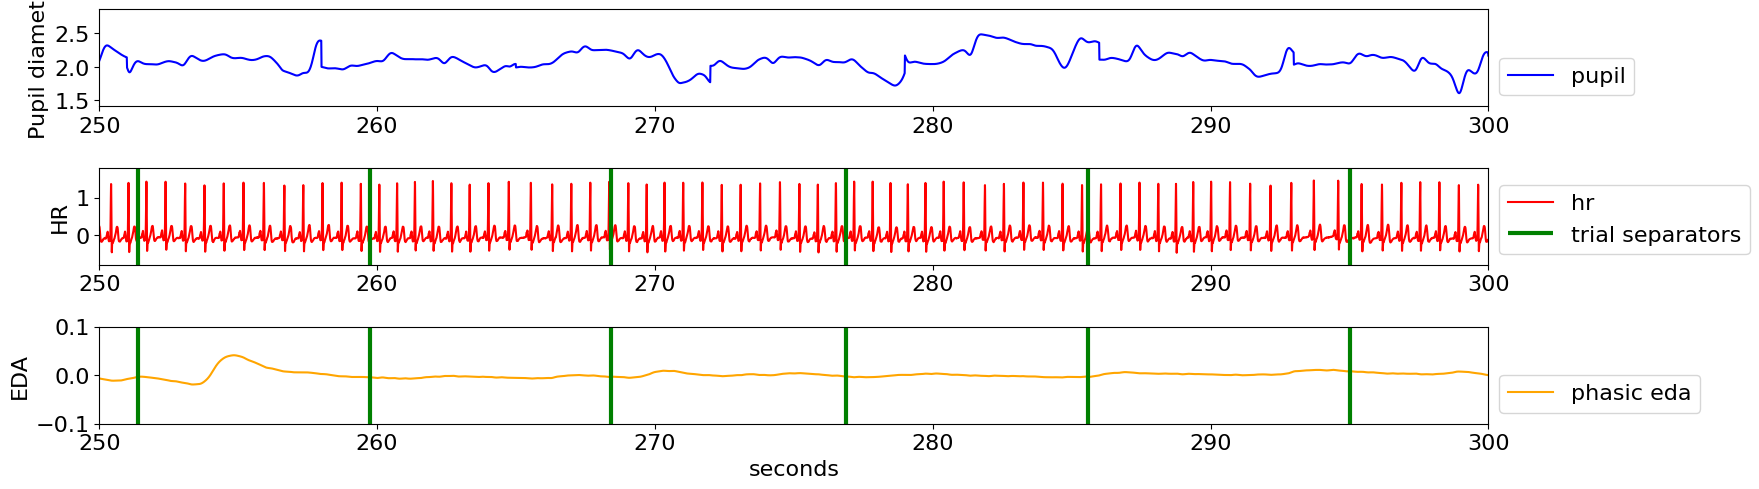

In [15]:
fig, ax = plt.subplots(3)
fig.tight_layout()

ax[0].plot(list(pupil_one_subj.time), list(pupil_one_subj.pupil_diameter),color='blue',label='pupil')
#ax[0].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[0].set(ylabel='Pupil diameter')
ax[0].set_xlim([250,300])
#ax[0].set_ylim([1.7, 2.3])
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].plot(list(eda_hr.time), list(eda_hr.hr),color='red',label='hr')
ax[1].set(ylabel='HR')
ax[1].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[1].legend()
ax[1].set_ylim([-0.8, 1.8])
ax[1].set_xlim([250, 300])
plt.xlabel('seconds')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].plot(list(eda_hr.time), list(eda_hr.phasic),color='orange',label='phasic eda')
ax[2].set(ylabel='EDA')
ax[2].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[2].set_ylim([-0.1, 0.1])
ax[2].set_xlim([250, 300])
plt.show()

In [16]:
eda_subj_1 = modified_eda_by_subject(1)
eda_subj_1

,subject,phasic,phasic_peak,time
0,1,-1.482637e-02,0,-5.000
1,1,-1.492123e-02,0,-4.998
2,1,-1.501798e-02,0,-4.996
3,1,-1.511662e-02,0,-4.994
4,1,-1.521713e-02,0,-4.992
...,...,...,...,...
1421031,1,1.232337e-06,0,2837.062
1421032,1,1.133891e-06,0,2837.064
1421033,1,1.029543e-06,0,2837.066
1421034,1,9.200323e-07,0,2837.068


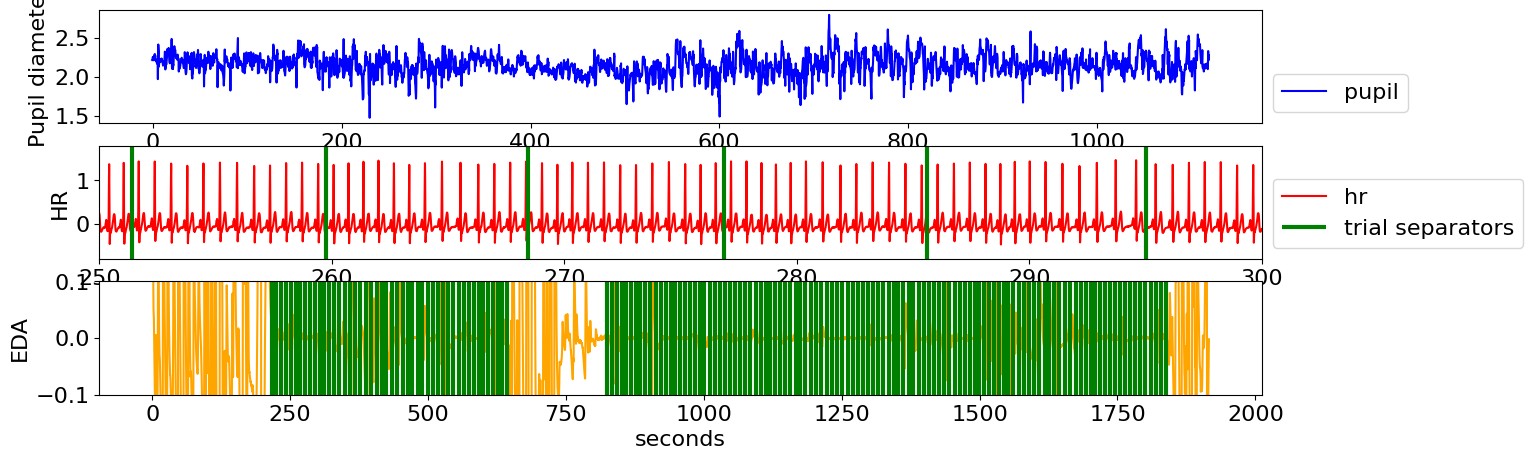

In [17]:
fig, ax = plt.subplots(3)
ax[0].plot(list(pupil_one_subj.time), list(pupil_one_subj.pupil_diameter),color='blue',label='pupil')
#ax[0].vlines(trial, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[0].set(ylabel='Pupil diameter')
#ax[0].set_ylim([1.7, 2.3])
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].plot(list(eda_hr.time), list(eda_hr.hr),color='red',label='hr')
ax[1].set(ylabel='HR')
ax[1].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[1].legend()
ax[1].set_ylim([-0.8, 1.8])
ax[1].set_xlim([250, 300])
plt.xlabel('seconds')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].plot(list(eda_hr.time), list(eda_hr.phasic),color='orange',label='phasic eda')
ax[2].set(ylabel='EDA')
ax[2].vlines(trials, ymin=-3,ymax=3, color='green', linewidth=3,label='trial separators')
ax[2].set_ylim([-0.1, 0.1])

plt.show()

In [18]:
diff_ = [x - trials[i - 1] for i, x in enumerate(trials)][1:]

print(min(diff_), max(diff_))

8.129999999999995 180.39200000000005


In [19]:
diff_

[8.29000000000002,
 8.406000000000006,
 8.97199999999998,
 8.846000000000004,
 8.352000000000032,
 8.685999999999979,
 8.456000000000017,
 8.699999999999989,
 9.435999999999979,
 8.376000000000033,
 8.371999999999957,
 8.23599999999999,
 9.698000000000036,
 8.873999999999967,
 10.07000000000005,
 9.005999999999972,
 10.052000000000021,
 9.45999999999998,
 9.910000000000025,
 9.829999999999984,
 9.812000000000012,
 9.322000000000003,
 8.339999999999975,
 10.004000000000019,
 10.053999999999974,
 9.590000000000032,
 9.061999999999955,
 8.236000000000047,
 9.94399999999996,
 8.670000000000016,
 9.22199999999998,
 9.951999999999998,
 9.870000000000061,
 9.0,
 8.197999999999979,
 9.593999999999937,
 9.644000000000005,
 9.272000000000048,
 9.524000000000001,
 8.687999999999988,
 8.81000000000006,
 8.615999999999985,
 8.419999999999959,
 8.79600000000005,
 8.663999999999987,
 8.38799999999992,
 8.734000000000037,
 180.39200000000005,
 9.889999999999986,
 8.563999999999965,
 8.628000000000043,

## create df hr e pupil signals

In [20]:
subject_number=2

In [21]:
hr_one_subj = extract_hr_by_subject(subject_number)
hr_one_subj

,subject,hr,trigger
0,02,-0.131683,0
1,02,-0.127258,0
2,02,-0.123749,0
3,02,-0.120087,0
4,02,-0.116577,0
...,...,...,...
960426,02,0.038452,0
960427,02,0.042267,0
960428,02,0.046539,0
960429,02,0.049744,0


In [22]:
def indexes_trial_start (df:pd.DataFrame)-> list:
    """
    Calculate indexes where trials starts
    :param df: a pandas DataFrame with rectangular function with value = 0 or value = 5 in column 2
    :return: a list that cointains indexes of firsts value with value = 5
    """
    start_trials = [] #TODO optimize this function.too much time
    prec = -1
    for i in tqdm(df.iterrows()):
        actual = i[1][2]
        if actual == 5 and prec == 0:
            start_trials.extend([i[0]])
        prec = actual
    return start_trials

def create_df_one_subj(df:pd.DataFrame,indexes_trial:list,type_data:str,sampling_rate=500,latency=0,len_trial=6) -> pd.DataFrame:
    """
    Modify pd dataframes trasforming datas into #numtrials rows and 3k columns similar to pupil data
    This function also fix latency

    :param df: df with a row for each value
    :param indexes_trial: list that cointains indexes of the df where starts trials
    :param type: str that indicates 'eda' or 'hr'
    :param sampling_rate: in hz default 500
    :param latency: in seconds default 0
    :param len_trial: in seconds default 6
    :return: DataFrame with 160 rows (1 per trial and 3k columns)
    """
    num_data = (len_trial*sampling_rate)-1
    names_col = np.arange(0,num_data+1).astype(str)
    df_all_trials = pd.DataFrame()
    for i,index in enumerate(indexes_trial):
        start_lat= index + (latency/1000*sampling_rate)
        end_lat = start_lat + num_data
        df_single_trial = df.loc[start_lat:end_lat][[type_data]]
        min_len= len(df_single_trial.index)
        df_single_trial.columns = [str(i+1)]
        df_trasp = df_single_trial.T
        df_trasp.columns =names_col[:min_len]
        df_all_trials = pd.concat([df_all_trials, df_trasp], axis=0)
    return df_all_trials

def from_csv_to_df (subject_number,valid_patients,type_data,path="tmp_eda") -> pd.DataFrame:
    """
    Read csv files from @param path and return a simple dataframe with eda (or hr) and trigger data

    :param subject_number:
    :param valid_patients:
    :param type_data:
    :param path:
    :return:
    """
    if type_data not in ['eda','hr']:
        print("ERROR TYPE_DATA PARAM (only eda or hr)")
        return

    if subject_number not in valid_patients:
        print('subject number not valid, probably this patient has not valid '+type_data+' signal')
        return []
    if subject_number < 10:
        subject_number = '0' + str(subject_number)
    path_csv = str(path+"/tmp_eda"+ str(subject_number) + ".csv")
    pat_ = pd.read_csv(path_csv)
    if type_data == 'eda':
        df = {'subject': subject_number, 'eda': pat_['CH1'], 'trigger': pat_['CH28']}
    if type_data == 'hr':
        df = {'subject': subject_number, 'hr': pat_['CH2'], 'trigger': pat_['CH28']}

    return pd.DataFrame(df)

def create_csv_signals_physio (subj_num, valid_patients,type_signal) -> None:
    """
    Function to create csv files into eda_csv or hr_csv folder
    :param subj_num:
    :param valid_patients:
    :param type_signal:
    :return:
    """
    if type_signal not in ['eda','hr']:
        print("ERROR TYPE_DATA PARAM (only eda or hr)")
        return
    df = from_csv_to_df(subj_num,valid_patients,type_data=type_signal)
    indexes_trial_ = indexes_trial_start(df)
    #print('len ind trial '+str(len(indexes_trial_)))
    if type_signal== 'eda':
        latency = LATENCY_EDA
    if type_signal== 'hr':
        latency = LATENCY_HR
    df_eda_subj = create_df_one_subj(df,indexes_trial=indexes_trial_,latency=latency,type_data=type_signal)
    name=type_signal+'_csv/'+str(subj_num)+'_'+type_signal+'.csv'
    df_eda_subj.to_csv(name,index=False)

## create csv files for hr

In [ ]:
for pat in valid_patients_hr:
    create_csv_signals_physio(pat,valid_patients_hr,type_signal='hr')

## create csv files for eda

In [ ]:
for pat in valid_patients_eda:
    create_csv_signals_physio(pat,valid_patients_eda,type_signal='eda')

# General idea to synchronize Heart rate signal, EDA signal and pupil diameter signal.

### EDA & HR
Thanks to Mario Reuter, we finally understood how to properly read *\<SubjectNumber\>.txt* files.
In particular **CH1** refers to EDA signals, **CH2** refers to HR signals while **CH28** refers to a *trigger* column: it contains *rectangular activation signals* that indicates the stimulus onset of each trial (the first non-zero value means that an image stimulus is presented to the subject).
* EDA
At this point since we know that the latency of the EDA signal is 5 seconds, we decide to discard the first 5 seconds of each trial (5*500 = 2500 rows, latency ) and consider the subsequent 6 seconds of the signal, that represent the duration of a trial before a fixation cross is presented to the subject. Even though a trial lasts for a period of time between 8-10 seconds, we have no issues since the latency is less than 8 seconds (in this case 5 s).
* HR
Same situation for the HR signals: in this case we have a latency of 250ms, so we discard for each trial the first 0.250*500 rows (latency * sampling rate HR)  after the corresponding trigger indicating the start of that trial.
* Pupil responses
The pupil diameters are stored for each subject in table containing 160 rows, one for trial, and 700 columns, representing the number of samples collected in 7 seconds for each trial. In this case we have to discard the first two seconds of each trial: the first is removed since this data are collected starting to the last second preceding stimulus onset while the second is removed because the latency of this signal is 1 second (this means removing the first 200 columns of each pupil file).


In [24]:
def new_read_pupil(subject:int, latency:int, sampling_rate: int) -> pd.DataFrame:
    """
    Read in current folder one tmp csv well formatted with pupil data
    :param subject:
    :param latency: msec
    :param sampling_rate: hz
    :return: Dataframe with pupil data of the subject
    """
    name = 'tmp_pupil/tmp_pupil'+str(subject)+'.csv'
    df_pupil = pd.read_csv(name, sep=',')
    delay_before_onset_stim = 1000
    len_col = int((latency+delay_before_onset_stim) / 1000 * sampling_rate)
    name_col = 'pd'
    columns = ['trial']
    for i in range(1, len_col+1):
        columns.append(name_col+str(i))
    df_pupil = df_pupil.drop(columns, axis=1)
    columns = np.arange(0, len(df_pupil.columns))
    df_pupil.columns = columns
    return df_pupil

In [25]:
pupil1 = new_read_pupil(1, 1000, 100)
pupil1

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.946893,1.948166,1.949541,1.951015,1.952582,1.954237,1.955973,1.957781,1.959654,1.961581,...,2.082965,2.082997,2.082784,2.082345,2.081702,2.080884,2.079921,2.078845,2.077688,2.076477
1,1.966207,1.966816,1.967371,1.967876,1.968335,1.968752,1.969134,1.969484,1.969809,1.970113,...,2.087581,2.088914,2.090180,2.091370,2.092475,2.093493,2.094421,2.095258,2.096007,2.096670
2,2.076144,2.076678,2.077227,2.077782,2.078332,2.078867,2.079378,2.079856,2.080294,2.080687,...,2.119693,2.120457,2.121158,2.121796,2.122370,2.122880,2.123324,2.123704,2.124020,2.124275
3,1.950334,1.950471,1.950710,1.951054,1.951504,1.952060,1.952720,1.953480,1.954332,1.955268,...,2.088751,2.090593,2.092342,2.094004,2.095585,2.097085,2.098506,2.099845,2.101097,2.102259
4,1.972522,1.973737,1.974976,1.976229,1.977489,1.978747,1.979993,1.981220,1.982421,1.983590,...,2.025596,2.026268,2.026895,2.027472,2.027995,2.028464,2.028877,2.029238,2.029547,2.029809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1.872694,1.873144,1.873739,1.874476,1.875353,1.876364,1.877497,1.878743,1.880087,1.881515,...,2.044166,2.043665,2.043047,2.042320,2.041492,2.040574,2.039581,2.038530,2.037440,2.036332
156,1.953122,1.954360,1.955689,1.957114,1.958639,1.960268,1.962005,1.963857,1.965825,1.967912,...,1.957294,1.957469,1.957620,1.957750,1.957860,1.957955,1.958036,1.958106,1.958167,1.958220
157,1.951408,1.953682,1.955936,1.958169,1.960381,1.962572,1.964741,1.966887,1.969007,1.971095,...,2.052764,2.052389,2.051991,2.051574,2.051140,2.050694,2.050240,2.049782,2.049325,2.048875
158,1.941912,1.941702,1.941440,1.941133,1.940783,1.940396,1.939976,1.939527,1.939055,1.938565,...,2.184578,2.184446,2.184223,2.183921,2.183551,2.183128,2.182666,2.182179,2.181677,2.181171


In [ ]:
def check_min_trial():
    dict_trials = {}
    for i in valid_patients_hr:
        hr_i = modified_hr_by_subject(i)
        trials = start_trial_time(hr_i)
        diff_ = [x - trials[i - 1] for i, x in enumerate(trials)][1:]
        dict_trials[i] = (min(diff_), max(diff_))
    return dict_trials


# recap

## eda
in folder eda_csv one csv for each patient with num rows = num trials
in each cell value of eda signal (tonic+phasic). num columns = 1/sampling rate*time trial
already considered latency of 5000 msec

## hr
in folder hr_csv one csv for each patient with num rows = num trials
in each cell value of hr signal (probably should consider hr variability not this signal). num columns = 1/sampling rate*time trial
already considered latency of 250 msec

## pupil

in folder pupil_csv one csv for each patient with num rows = num trials
in each cell value of pupil dilation. num columns = 1/sampling rate*time trial
already considered latency of 1000 msec and removed first second (inter-trial time)




At this point we need only to read data from this csvs and plot

In [26]:
subject_number=2
trial_numb = 80

In [27]:
eda_subj = pd.read_csv('eda_csv/'+str(subject_number)+'_eda.csv')
hr_subj = pd.read_csv('hr_csv/'+str(subject_number)+'_hr.csv')
pupil_subj = pd.read_csv('pupil_csv/'+str(subject_number)+'_pupil.csv')

how to plot division more trial?

In [28]:
eda_trial = eda_subj.loc[trial_numb]
hr_trial = hr_subj.loc[trial_numb]
pupil_trial = pupil_subj.loc[trial_numb]

In [29]:
X_hr_eda = np.arange(0, 6, 0.002)
X_pupil = np.arange(0, 5, 0.01)
X_hr_eda

array([0.000e+00, 2.000e-03, 4.000e-03, ..., 5.994e+00, 5.996e+00,
       5.998e+00])

In [30]:
df, info = nk.ecg_process(list(hr_trial), sampling_rate=SAMPLING_RATE_HR)
ecg_rate_trial = df['ECG_Rate']

/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():


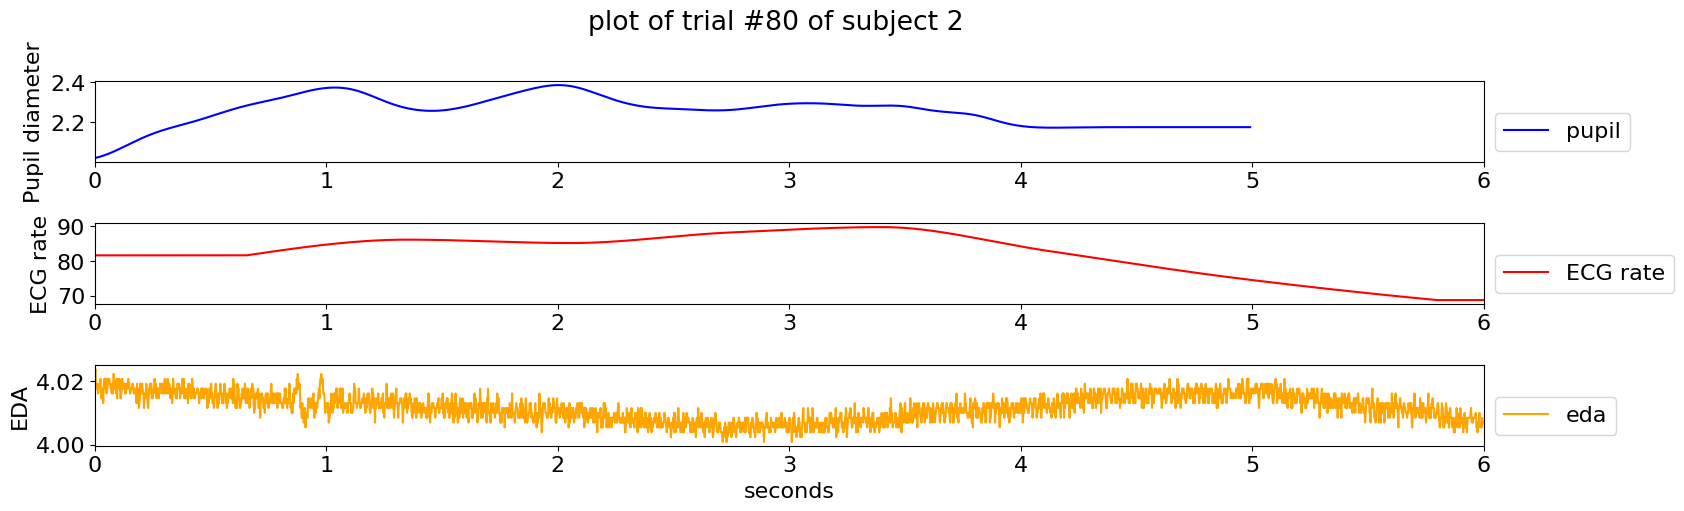

In [31]:
fig, ax = plt.subplots(3)
fig.suptitle('plot of trial #'+str(trial_numb)+' of subject '+str(subject_number))
fig.tight_layout()

ax[0].plot(X_pupil, list(pupil_trial),color='blue',label='pupil')
ax[0].set(ylabel='Pupil diameter')
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[0].set_xlim([0, 6])

#list(hr_trial)
ax[1].plot(X_hr_eda, list(ecg_rate_trial),color='red',label='ECG rate')
ax[1].set(ylabel='ECG rate')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[1].set_xlim([0, 6])

ax[2].plot(X_hr_eda,list(eda_trial),color='orange',label='eda')
ax[2].set(ylabel='EDA')
ax[2].legend(bbox_to_anchor=(1,0), loc="lower left")
ax[2].set_xlim([0, 6])

plt.xlabel('seconds')
plt.show()

In [39]:
def create_single_signal_lists(df_pupil, df_eda, df_hr):
    list_pupil, list_eda, list_hr = [], [], []
    for i in range(len(df_pupil)):
        raw_list = df_pupil.loc[i, :].values.flatten().tolist()
        list_pupil = list_pupil + raw_list
        list_pupil.extend([float('NaN') for x in range(100)])
    for i in range(len(df_eda)):
        raw_list = df_eda.loc[i, :].values.flatten().tolist()
        list_eda = list_eda + raw_list
    for i in range(len(df_hr)):
        raw_list = df_hr.loc[i, :].values.flatten().tolist()
        df, info = nk.ecg_process(raw_list, sampling_rate=SAMPLING_RATE_HR)
        ecg_rate_trial = df['ECG_Rate']
        list_hr = list_hr + list(ecg_rate_trial)
    return list_pupil, list_eda, list_hr

list_pupil, list_eda, list_hr = create_single_signal_lists(pupil_subj, eda_subj, hr_subj)

/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2/epochs/epochs_create.py:205: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for colname, column in epochs[i].select_dtypes(include=["object"]).iteritems():
/Users/marcoghezzi/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/neurokit2

In [40]:
X_pupil = np.arange(0, NUM_TRIALS*6, 0.01)
X_hr_eda = np.arange(0, NUM_TRIALS*6, 0.002)

In [41]:
def start_end_trial(start_trial, len_trial, len_column):
    list_start = start_trial*len_column
    list_end = list_start+(len_column*len_trial)
    return list_start, list_end

In [42]:
starting_trial = 138
len_trial = 7
pup_start, pup_end = start_end_trial(starting_trial, len_trial, 600)
hr_start, hr_end = start_end_trial(starting_trial, len_trial, 3000)
eda_start, eda_end = start_end_trial(starting_trial, len_trial, 3000)

def extract_trials_lines(df, start, end):
    trials_lines = []
    for x in df[start:end]:
        if x % 6 == 0:
            trials_lines.append(x)
    return trials_lines

trials = extract_trials_lines(X_pupil, pup_start, pup_end)

In [43]:
shock_timestamp = 5.85
name = 'LookAtMe_0'
if subject_number < 10:
    name += '0'+str(subject_number)+'.csv'
else:
    name += str(subject_number)+'.csv'
look_at_me = pd.read_csv('../osfstorage-archive/behavior/'+name, sep='\t')
trial_with_us = look_at_me[look_at_me.shock==True]
trial_with_us=trial_with_us[(trial_with_us['trial'] >= starting_trial) & (trial_with_us['trial'] <= starting_trial+len_trial)]
trial_with_us

,expName,subject,pairs,cs1,cs2,block,trial,condition,rating,rt,shock,picName,timestamp
137,LookAtMe,2,2,2,2,2,138,26,4,0.765133,True,stim\4 M078C.jpg,2018-12-18 17:10:40
142,LookAtMe,2,2,2,2,2,143,36,5,0.754955,True,stim\6 F053C.jpg,2018-12-18 17:11:28


In [44]:
timestamp_shock = [x*6+shock_timestamp for x in trial_with_us.trial.values.tolist()]
timestamp_shock

[833.85, 863.85]

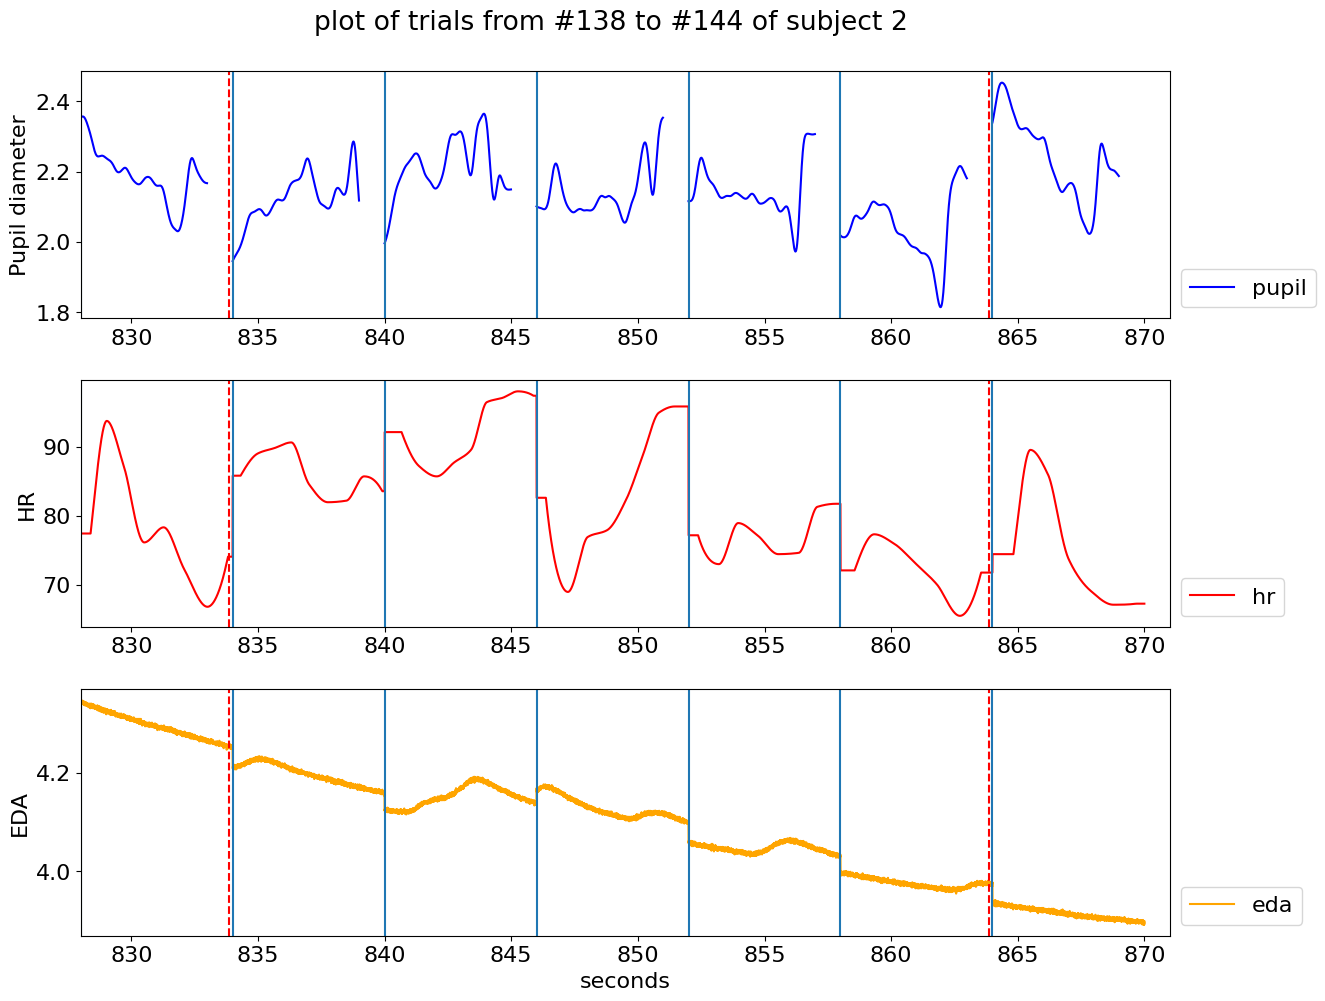

In [45]:
fig, ax = plt.subplots(3, figsize=(12,10))
fig.suptitle('plot of trials from #'+str(starting_trial)+' to #'+str(len_trial+starting_trial-1) +' of subject '+str(subject_number))
fig.tight_layout()

ax[0].plot(X_pupil[pup_start:pup_end], list_pupil[pup_start:pup_end],color='blue',label='pupil')
ax[0].set(ylabel='Pupil diameter')
ax[0].legend(bbox_to_anchor=(1,0), loc="lower left")
for j in trials:
    ax[0].axvline(j)
ax[0].set_xlim([X_pupil[pup_start], X_pupil[pup_end]+1])
for i in timestamp_shock:
    ax[0].axvline(i,color='red', linestyle='--')

ax[1].plot(X_hr_eda[hr_start:hr_end], list_hr[hr_start:hr_end],color='red',label='hr')
ax[1].set(ylabel='HR')
ax[1].legend(bbox_to_anchor=(1,0), loc="lower left")
for j in trials:
    ax[1].axvline(j)
ax[1].set_xlim([X_hr_eda[hr_start], X_hr_eda[hr_end]+1])
for i in timestamp_shock:
    ax[1].axvline(i,color='red', linestyle='--')

ax[2].plot(X_hr_eda[hr_start:hr_end],list_eda[eda_start:eda_end],color='orange',label='eda')
ax[2].set(ylabel='EDA')
ax[2].legend(bbox_to_anchor=(1,0), loc="lower left")
for j in trials:
    ax[2].axvline(j)
ax[2].set_xlim([X_hr_eda[hr_start], X_hr_eda[hr_end]+1])
for i in timestamp_shock:
    ax[2].axvline(i,color='red', linestyle='--')


plt.xlabel('seconds')
plt.show()

## social anxiety

TODO approfondire questione righe 5,9,11

In [46]:
def create_csv_sias(filename='sias_score.csv',quest_path='../osfstorage-archive/Questionnaires.xlsx'):

    df = pd.read_excel(quest_path)

    cols = ['SIAS01', 'SIAS02', 'SIAS03', 'SIAS04', 'SIAS05', 'SIAS06',
           'SIAS07', 'SIAS08', 'SIAS09', 'SIAS10', 'SIAS11', 'SIAS12', 'SIAS13',
           'SIAS14', 'SIAS15', 'SIAS16', 'SIAS17', 'SIAS18', 'SIAS19', 'SIAS20']

    #find sum of columns specified
    for j in range(len(df)):
        for col in df.columns:
            if df.loc[j][col] == 'MV':
                df.at[j,col] = np.nan
    df['sias_score'] = df[cols].sum(axis=1,min_count=20)
    df_sias = df[['VP','sias_score']]
    df_sias.rename(columns = {'VP':'subject'}, inplace = True)
    df_sias['social_anxiety'] = [1 if x>=36 else 0 for x in df['sias_score']]
    df_sias.to_csv(filename, index=False)

## create csv for social anxiety

In [ ]:
create_csv_sias()

## read csv for social anxiety

In [47]:
df_sias = pd.read_csv('sias_score.csv')
df_sias

,subject,sias_score,social_anxiety
0,1,21.0,0
1,2,11.0,0
2,3,30.0,0
3,4,12.0,0
4,5,30.0,0
5,6,8.0,0
6,7,25.0,0
7,8,6.0,0
8,9,NaN,0
9,10,10.0,0
